Epoch 1 - Train Acc: 0.3164, Val Acc: 0.2714


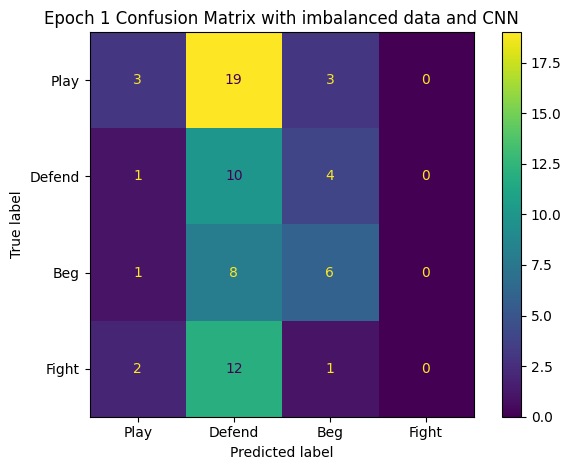

Epoch 2 - Train Acc: 0.4463, Val Acc: 0.3143


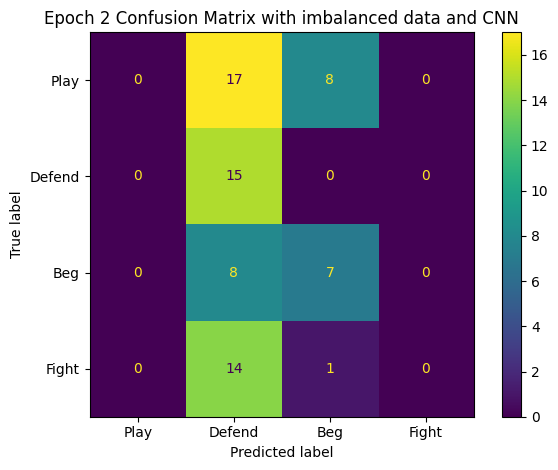

Epoch 3 - Train Acc: 0.4576, Val Acc: 0.3714


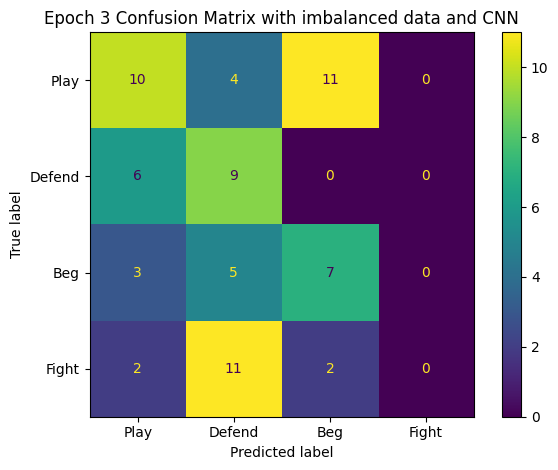

Epoch 4 - Train Acc: 0.4350, Val Acc: 0.2571


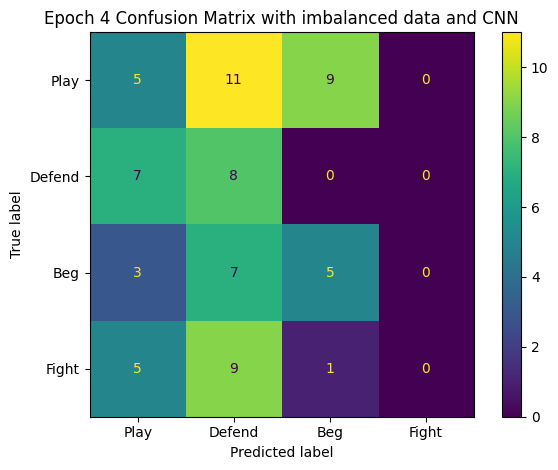

Epoch 5 - Train Acc: 0.4237, Val Acc: 0.2714


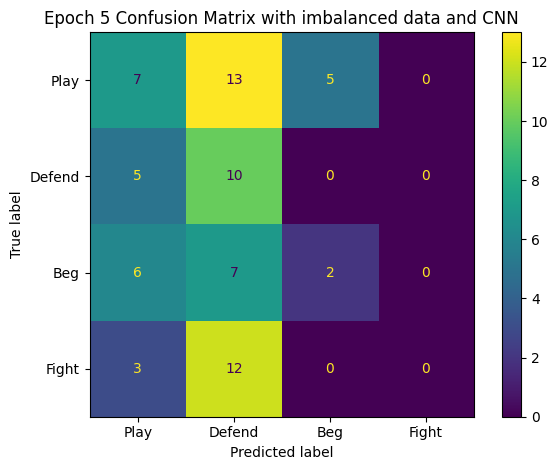

Epoch 6 - Train Acc: 0.4859, Val Acc: 0.3286


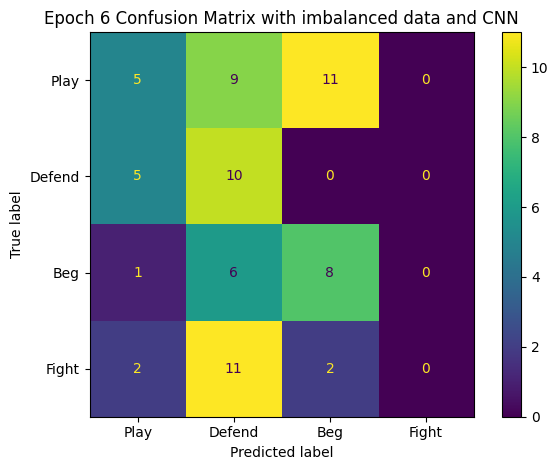

Epoch 7 - Train Acc: 0.4181, Val Acc: 0.2857


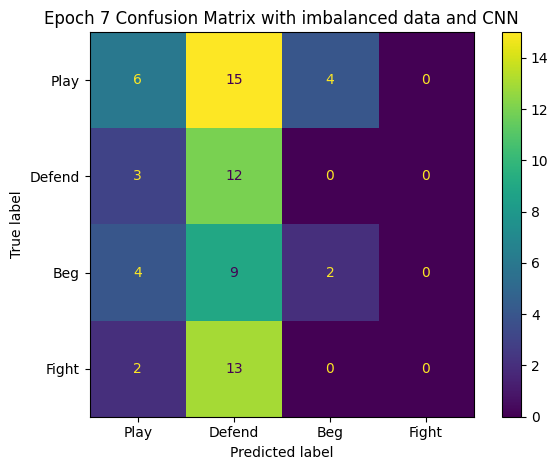

Epoch 8 - Train Acc: 0.4520, Val Acc: 0.3429


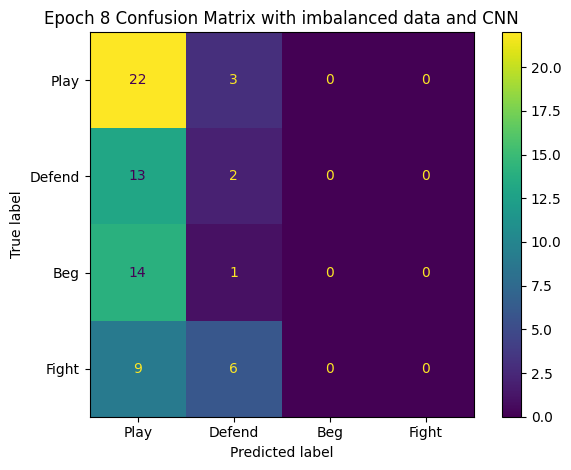

Epoch 9 - Train Acc: 0.4407, Val Acc: 0.3143


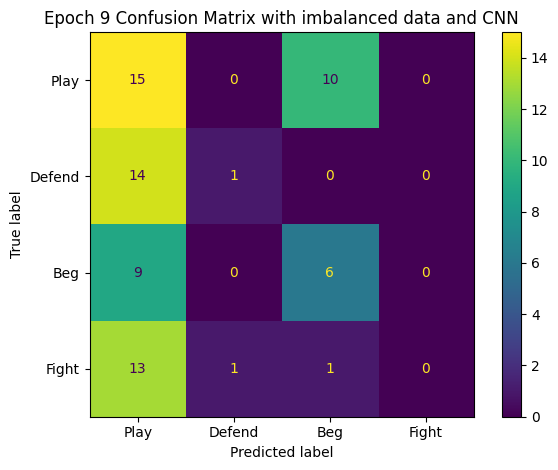

Epoch 10 - Train Acc: 0.4689, Val Acc: 0.3000


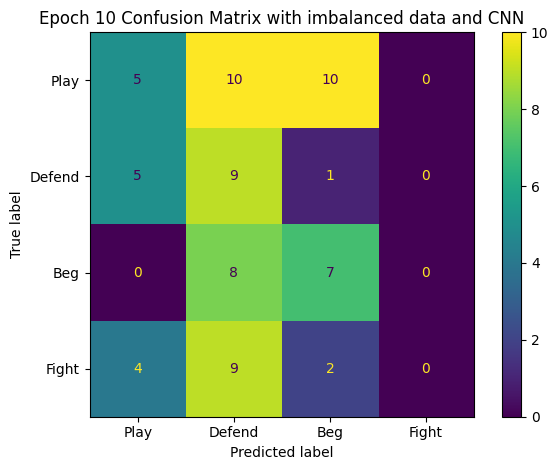

In [ ]:
import torch, torchaudio, os, random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LABELS = {"Play": 0, "Defend": 1, "Beg": 2, "Fight": 3}
INV_LABELS = {v: k for k, v in LABELS.items()}
SAMPLE_RATE = 16000
class DogMelDataset(Dataset):
    def __init__(self, base_path, folders, split="train"):
        self.items = []
        for folder in folders:
            subfolder = "train_wav" if split == "train" else "val_wav"
            full_path = os.path.join(base_path, folder, subfolder)
            if not os.path.exists(full_path):
                print(f"No such path: {full_path}")
                continue

            label = LABELS[folder]
            files = [f for f in os.listdir(full_path) if f.endswith(".wav")]
            for f in files:
                self.items.append((os.path.join(full_path, f), label))

        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, label = self.items[idx]
        wav, sr = torchaudio.load(path)
        if sr != SAMPLE_RATE:
            wav = torchaudio.functional.resample(wav, sr, SAMPLE_RATE)
        wav = wav.mean(dim=0)  # Mono
        wav = wav / (wav.abs().max() + 1e-8)

        mel = self.mel_spec(wav).clamp(min=1e-5).log10()  # shape: (64, T)
        mel = mel.unsqueeze(0)  # shape: (1, 64, T)

        target_length = 300
        if mel.size(2) < target_length:
            pad_amt = target_length - mel.size(2)
            mel = F.pad(mel, (0, pad_amt))  # pad time dim to right
        else:
            mel = mel[:, :, :target_length]  # crop to max

        return mel, torch.tensor(label)

        
def get_loaders(base_path, batch_size=16):
    train_ds = DogMelDataset(base_path, LABELS.keys(), "train")
    val_ds = DogMelDataset(base_path, LABELS.keys(), "val")
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader
class CNNClassifier(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # [B, 16, 64, T]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                  # [B, 16, 32, T/2]

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                  # [B, 32, 16, T/4]

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))                           # [B, 64, 1, 1]
        )
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        out = self.net(x)
        out = out.view(out.size(0), -1)  # flatten
        return self.fc(out)
def train(model, train_loader, val_loader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = correct = count = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (logits.argmax(1) == y).sum().item()
            count += y.size(0)

        val_acc, preds, trues = evaluate(model, val_loader)
        print(f"Epoch {epoch+1} - Train Acc: {correct/count:.4f}, Val Acc: {val_acc:.4f}")
        plot_cm(trues, preds, epoch+1)

def evaluate(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            pred = logits.argmax(1).cpu()
            preds.extend(pred.tolist())
            trues.extend(y.tolist())
    acc = sum([p == t for p, t in zip(preds, trues)]) / len(trues)
    return acc, preds, trues

def plot_cm(trues, preds, epoch):
    cm = confusion_matrix(trues, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=LABELS.keys())
    disp.plot()
    plt.title(f"Epoch {epoch} Confusion Matrix with imbalanced data and CNN")
    plt.tight_layout()
    plt.show()
    
base_path = "/kaggle/input/dog-dataset/dog_clips-20250528T014737Z-1-001/dog_clips/Labels"
train_loader, val_loader = get_loaders(base_path)
model = CNNClassifier().to(device)
train(model, train_loader, val_loader, epochs=10)
